In [81]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

In [82]:
root_path = "/home/cdq/FedPet/log/yahoo/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001"

data_point_list = [1, 2]
num_clients_infer_list = [5, 10, 15, 20] 
infer_freq_list = [1, 2, 4]




In [83]:
max_acc = []
df_main = pd.DataFrame(index = data_point_list, columns = pd.MultiIndex.from_product([num_clients_infer_list,
                                                    infer_freq_list]))
df_conver_round = pd.DataFrame(index = data_point_list, columns = pd.MultiIndex.from_product([num_clients_infer_list,
                                                    infer_freq_list]))

/home/cdq/.conda/envs/ptpretrain/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


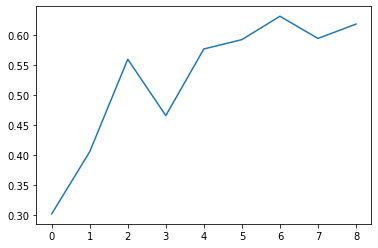

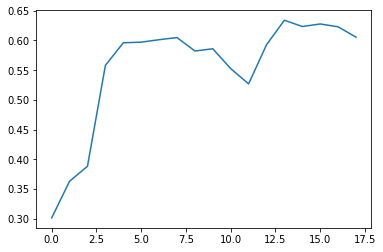

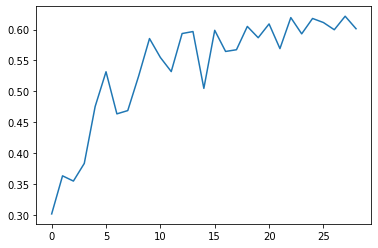

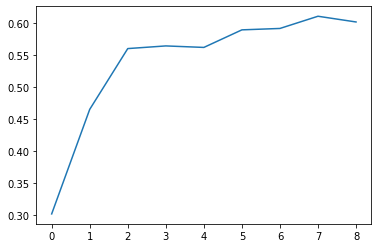

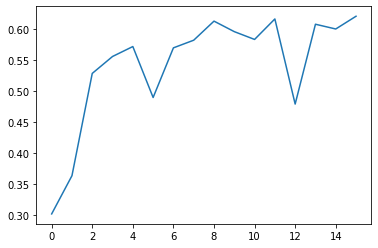

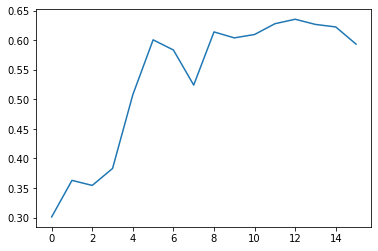

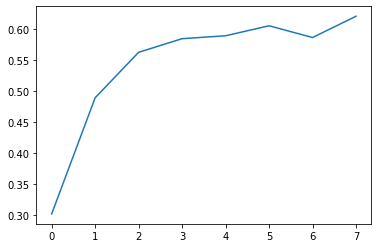

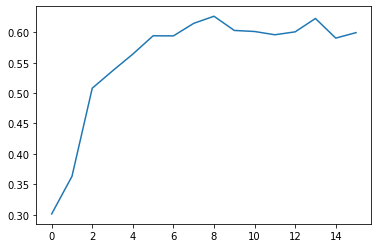

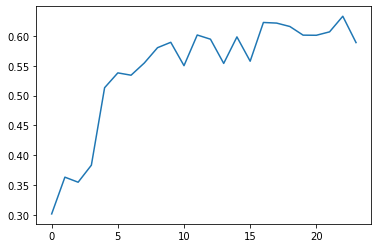

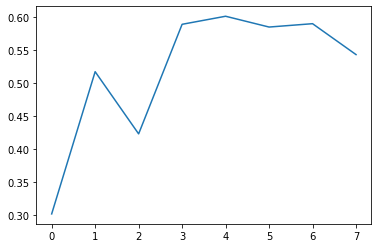

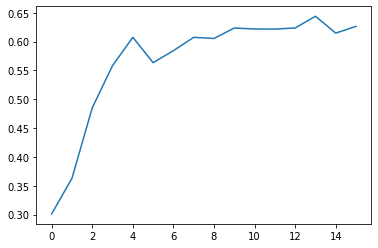

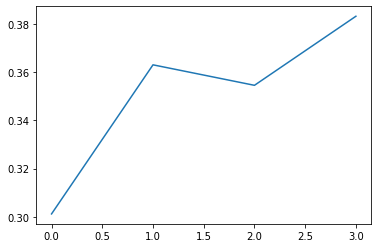

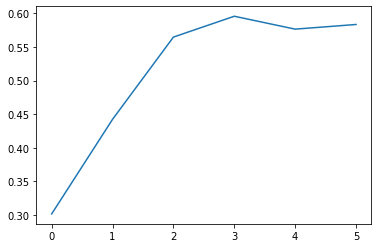

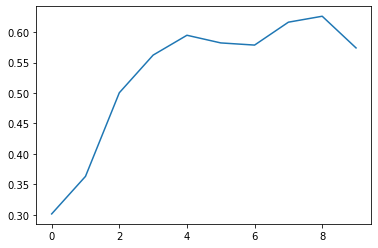

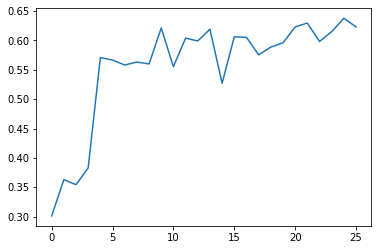

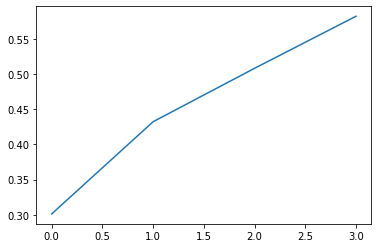

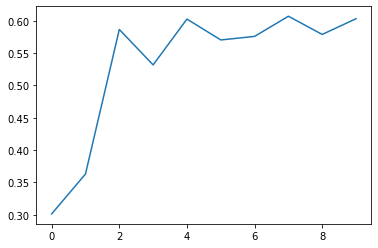

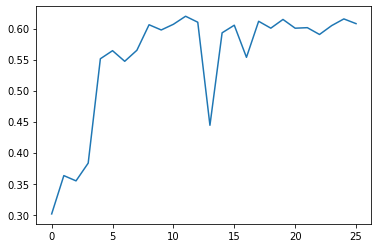

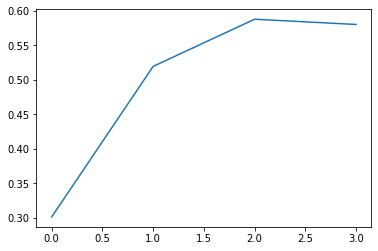

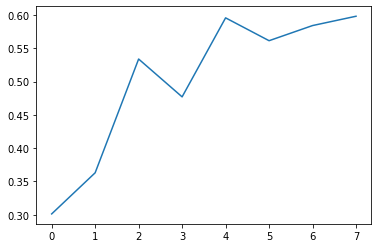

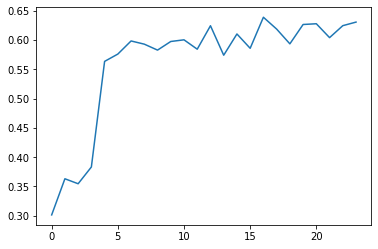

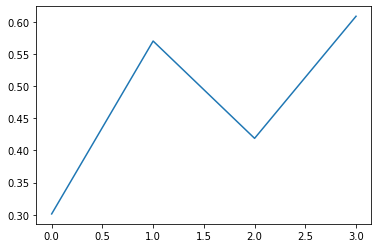

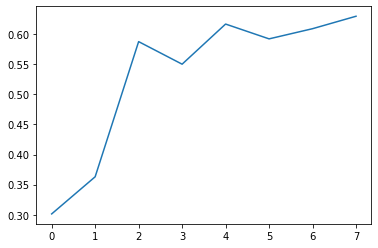

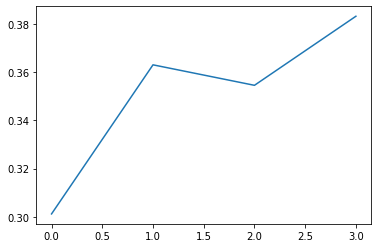

In [85]:
# round to accuracy

for data_point in data_point_list:
    for num_clients_infer in num_clients_infer_list:
        for infer_freq in infer_freq_list:
            fig = plt.figure()
            
            filename = f"new_all_aug_{data_point}_conver_0_limit_0_fedpet_64_32_roberta-base_{num_clients_infer}_{infer_freq}.log"
            log_path = os.path.join(root_path, filename)
            if not os.path.exists(log_path):
                df_main.loc[data_point, num_clients_infer][infer_freq] = None
                print(f"{log_path} not exists")
                continue


            # plt.title(log_path)
            iter = 1000
            phrase = 'aggregated model performance is'
            with open(log_path) as f:
                f = f.readlines()
            df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
            for line in f:
                if phrase in line:
                    gen = int(re.findall(r'Gen (.+?) ',line)[0])
                    
                    acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                    df[0][gen]=acc

            df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
            if df.empty:
                print(f"Bug: {log_path}")

            # print(filename)
            # print(df)
            this_max_acc = np.max(df[0])
            idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
            # print(f"max accuracy is {this_max_acc}, round is {idx}")
            df_main.loc[data_point, num_clients_infer][infer_freq] = np.max(this_max_acc)
            df_conver_round.loc[data_point, num_clients_infer][infer_freq] = [idx]

            # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
            iter = len(df.index)
            y_mean = []
            for j in range(iter):
                y = np.array(df.iloc[j])

                y_mean.append(pd.DataFrame(y).dropna().mean())
                # plt.scatter(j, y)
                    
            plt.plot(range(iter),y_mean)
            # fig.savefig(f"../fig/augment-yelp-{filename}.pdf")

In [86]:
df_main

5                             10                            15  \
          1         2         4         1         2         4         1   
1  0.631383  0.633967  0.621717  0.610733  0.620583  0.635367  0.620933   
2    0.5959  0.626333  0.637883  0.581917  0.606867  0.619767  0.587417   

                             20                    
          2         4         1         2       4  
1   0.62635    0.6333  0.601317  0.643917  0.3831  
2  0.598017  0.638883    0.6089  0.629933  0.3831

In [87]:
df_conver_round

5                10               15              20           
     1     2     4    1     2     4    1    2     4    1     2    4
1  [6]  [13]  [27]  [7]  [15]  [12]  [7]  [8]  [22]  [4]  [13]  [3]
2  [3]   [8]  [24]  [3]   [7]  [11]  [2]  [7]  [16]  [3]   [7]  [3]

9 9
18 18
29 29
9 9
16 16
17 16
8 8
16 16
24 24
8 8
16 16
4 4
6 6
10 10
27 26
4 4
10 10
26 26
4 4
8 8
25 24
4 4
8 8
4 4


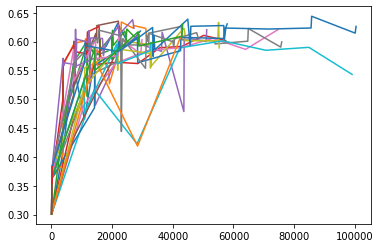

In [96]:
# time to accuracy
df_runtime = pd.DataFrame(index = data_point_list, columns = pd.MultiIndex.from_product([num_clients_infer_list,
                                                    infer_freq_list]))
df_train_time = pd.DataFrame(index = data_point_list, columns = pd.MultiIndex.from_product([num_clients_infer_list,
                                                    infer_freq_list]))                
df_infer_time = pd.DataFrame(index = data_point_list, columns = pd.MultiIndex.from_product([num_clients_infer_list,
                                                    infer_freq_list]))                                                                                                                                                
fig = plt.figure()
for data_point in data_point_list:
    for num_clients_infer in num_clients_infer_list:
        for infer_freq in infer_freq_list:

            filename = f"new_all_aug_{data_point}_conver_0_limit_0_fedpet_64_32_roberta-base_{num_clients_infer}_{infer_freq}.log"
            log_path = os.path.join(root_path, filename)
            if not os.path.exists(log_path):
                df_main.loc[data_point, num_clients_infer][infer_freq] = None
                print(f"{log_path} not exists")
                continue

            conver_point = df_conver_round.loc[data_point, num_clients_infer][infer_freq]

            iter = 1000
            phrase = 'train data'
            with open(log_path) as f:
                f = f.readlines()
            df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
            runtime = []
            train_runtime = []
            infer_runtime = []
            time_stamp = 0
            train_time_stamp = 0
            infer_time_stamp = 0

            for line in f:
                if phrase in line:
                    line_idx = f.index(line)
                    
                    train_info = f[line_idx]
                    infer_info = f[line_idx + 1]
                    
                    # TX2: train, 1s/sample, infer, 0.5s/sample
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * 1 
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * 0.5
                    
                    time_stamp = time_stamp + train_time + infer_time # elasped time of all clients / energy consumption
                    train_time_stamp = train_time + train_time_stamp
                    infer_time_stamp = infer_time + infer_time_stamp

                    runtime.append(time_stamp)
                    train_runtime.append(train_time_stamp)
                    infer_runtime.append(infer_time_stamp)
                if 'aggregated model performance is' in line: 
                    gen = int(re.findall(r'Gen (.+?) ',line)[0])
                    
                    acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                    df[0][gen]=acc

            df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
            if df.empty:
                print(f"Bug: {log_path}")

            this_max_acc = np.max(df[0])
            idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
            # print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
            df_main.loc[data_point, num_clients_infer][infer_freq] = np.max(this_max_acc)
            df_runtime.loc[data_point, num_clients_infer][infer_freq] = np.max(runtime[idx])
            df_train_time.loc[data_point, num_clients_infer][infer_freq] = np.max(train_runtime[idx])
            df_infer_time.loc[data_point, num_clients_infer][infer_freq] = np.max(infer_runtime[idx])

            # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
            iter = len(df.index)
            y_mean = []
            for j in range(iter):
                y = np.array(df.iloc[j])

                y_mean.append(pd.DataFrame(y).dropna().mean())
                # plt.scatter(j, y)
            print(len(runtime),len(list(map(float, y_mean))))
            plt.plot(runtime[:len(y_mean)],y_mean)
            fig.savefig(f"../fig/augment-yahoo-all.pdf")

整个runtime 由训练时间还有推理时间组成。训练时间会随着训练轮数（augment）的增加而增加（*alpha*），而推理时间则是与 *N，K* 增强频率与选择要增强的设备有关

确定了这些变量之后
有哪些有意思的方法可以提升其效率呢？**（重点思考）**

In [90]:
# Unit: s
df_train_time

5                 10                15               20           
     1     2     4     1     2     4     1     2     4    1     2    4
1  812  2031  3827  1197  2177  1062  1231   830  2578  529  1765  256
2  609  1711  5755   542  1130  1594   347  1275  2939  625  1235  256

In [91]:
# Unit: s
df_infer_time

5                          10                         15           \
         1        2        4        1        2        4        1        2   
1  21000.0  21000.0  21000.0  49000.0  49000.0  21000.0  73500.0  42000.0   
2  10500.0  14000.0  21000.0  21000.0  21000.0  14000.0  21000.0  31500.0   

                 20                
         4        1        2    4  
1  52500.0  56000.0  84000.0  0.0  
2  42000.0  42000.0  42000.0  0.0

In [92]:
df_train_time/df_infer_time

5                             10                            15  \
          1         2         4         1         2         4         1   
1  0.038667  0.096714  0.182238  0.024429  0.044429  0.050571  0.016748   
2     0.058  0.122214  0.274048   0.02581   0.05381  0.113857  0.016524   

                             20                 
          2         4         1         2    4  
1  0.019762  0.049105  0.009446  0.021012  inf  
2  0.040476  0.069976  0.014881  0.029405  inf

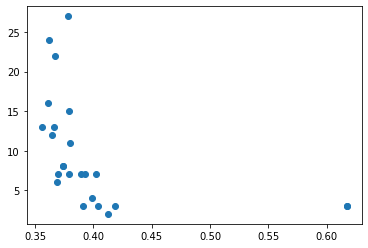

In [93]:
plt.scatter(1- np.concatenate(df_main.values.tolist()), np.concatenate(df_conver_round.values.tolist()))
# plt.savefig("../fig/augment-agnews-conver-round.pdf")

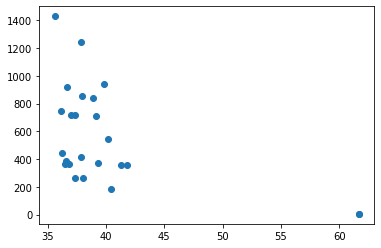

In [95]:
plt.scatter((1- np.concatenate(df_main.values.tolist()))*100, np.concatenate(df_runtime.values.tolist())/60)
plt.savefig("../fig/augment-yahoo-runtime.pdf")

In [30]:
1-np.concatenate(df_main.values.tolist())

array([0.13434211, 0.13934211, 0.23092105, 0.14118421, 0.13684211,
       0.13644737, 0.15302632, 0.15644737, 0.15960526, 0.13263158,
       0.13342105, 0.14868421, 0.14315789, 0.13776316, 0.15302632,
       0.13421053, 0.14092105, 0.155     , 0.13763158, 0.13644737,
       0.14578947, 0.13710526, 0.14671053, 0.13986842, 0.13236842,
       0.13421053, 0.14486842, 0.14289474, 0.13105263, 0.13986842,
       0.12960526, 0.13578947, 0.14131579, 0.13697368, 0.1325    ,
       0.13434211, 0.15526316, 0.15184211, 0.13315789, 0.14947368,
       0.13934211, 0.12842105, 0.17934211, 0.135     , 0.13026316,
       0.16144737, 0.13460526, 0.12723684])

In [35]:

sum(list(map(int, re.findall(r'\d+', "17806 - Sun, 23 Oct 2022 18:35:17 utils.py[line:52] INFO Gen 1: client_indexes is [507 818 452 368 242]".split("Gen")[1]))))

2388